<a href="https://colab.research.google.com/github/sangmin213/YOLOv3/blob/main/Yolo_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torchvision

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

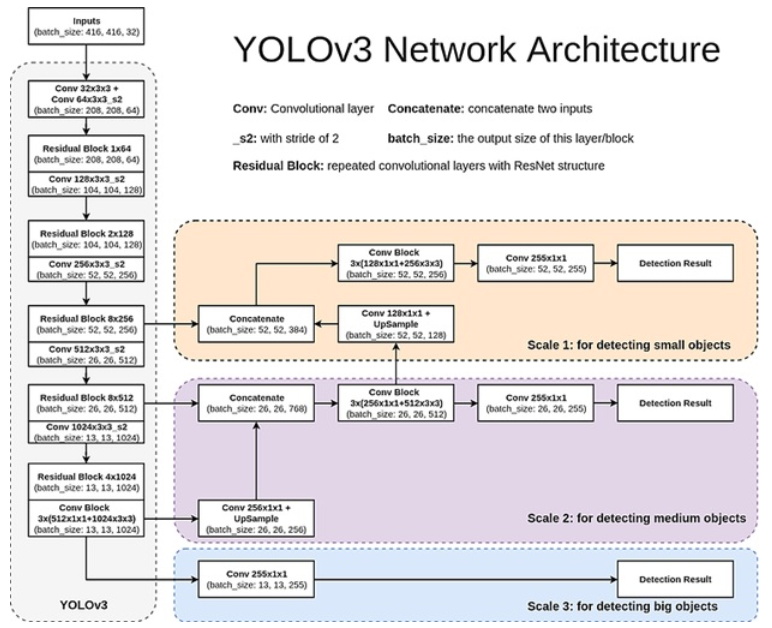

사진 출처: https://herbwood.tistory.com/21

In [ ]:
class Block(nn.Module):
    def __init__(self,in_channel,filter_num): # filter_num은 list 형태
        super(Block,self).__init__()

        self.conv1=nn.Conv2d(in_channel,filter_num[0],kernel_size=1)
        self.bn1=nn.BatchNorm2d(filter_num[0],momentum=0.9)
        self.conv2=nn.Conv2d(filter_num[0],filter_num[1],kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(filter_num[1],momentum=0.9)
        self.activation=nn.LeakyReLU()
        self.layer=nn.Sequential(self.conv1, self.bn1, self.activation, self.conv2, self.bn2, self.activation)

    def forward(self,x):
        y = self.layer(x)
        y = y + x  # residual

        return y

In [ ]:
class DownSample(nn.Module):
    def __init__(self,in_channel,out_channel): # filter_num은 list 형태
        super(DownSample,self).__init__()
        
        self.conv=nn.Conv2d(in_channel,out_channel,kernel_size=3,stride=2,padding=1)
        self.bn=nn.BatchNorm2d(out_channel,momentum=0.9)
        self.activation=nn.LeakyReLU()
        self.layer=nn.Sequential(self.conv, self.bn, self.activation)

    def forward(self,x):
        y = self.layer(x)

        return y

In [ ]:
# FPN Top-down pathway
class TopDown(nn.Module):
    def __init__(self,lower_channel,upper_in_channel,upper_out_channel, param=False,num_class): # FPN의 피라미드에서의 lower, upper 층, 
        super(TopDown,self).__init__()
        self.param=param # param은 한번 더 big->middle에서 middle->small로 한번 더 가야하는지 판단. 위 그림에서 보라색->주황색 연결다리

        self.conv1=nn.Conv2d(upper_in_channel,upper_out_channel,1) # ex) 1024 -> 256
        self.upsample=nn.Upsample(scale_factor=2)

        self.block=Block(lower_channel+upper_out_channel,[upper_out_channel,lower_channel]) # 512+256 -> 256*1*1 & 512*3*3
        self.conv2=nn.Conv2d(lower_channel,3*(4+1+num_class),1) # ex) 512 -> 255
        # 최종 ouput이 255인 이유: 3*(4+1+um_class)
        # 3: grid cell 당 예측하는 anchor box의 수 -> small, middle, big
        # 4: bounding box offset
        # 1: objectness score
        # 80: coco dataset의 class 개수
        # 3*(4+1+80) = 255

    def forward(self,x1,x2): # x1은 낮은 layer, x2는 높은 layer
        x2 = self.conv1(x2)
        x2 = self.upsample(x2)
        y = torch.cat((x1,x2),dim=1) # lateral connection
        y = self.block(y)
        if self.param:
            return y
        y = self.conv2(y)

        return y

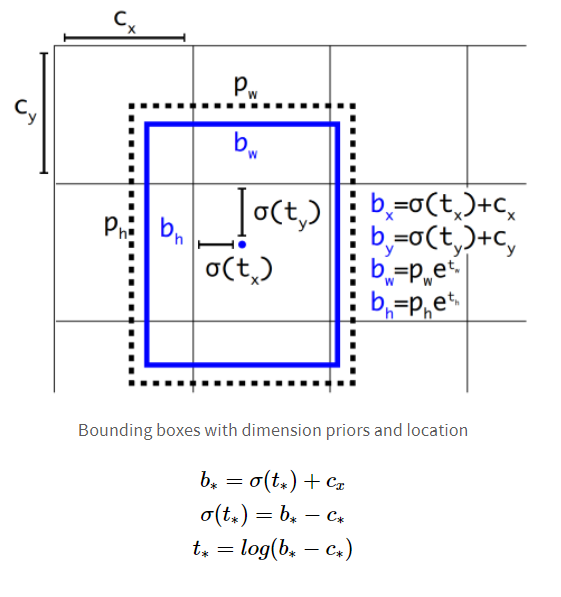

In [ ]:
class YOLO(nn.Module):
    def __init__(self,grid_size,num_class):
        super(YOLO,self).__init__()
        self.grid_size=grid_size
        self.num_class=num_class
        self.img_size=416 # 실제 input 이미지에 bounding box를 구성해야하기 때문

        if self.num_class==13:
            self.anchors=[(116,90), (156,198), (373,326)]
        if self.num_class==26:
            self.anchors=[(30,61), (62,45), (59,119)]
        elif self.num_class==52:
            self.anchors=[(10,13), (16,30), (33,23)]

    def forward(self,x): 
        self.grid_size=x.shape[2] # (batch,channel,row,col) ex. = (batch,255,13,13) --> 13

        self.pred = x.view(x.shape[0].x.shape[2],x.shape[3],x.shape[1])
              
        

        return y

    def normalize_anchor_box(self):
        self.stride = self.img_size/self.grid_size # offset 표현
        
        # grid
        self.grid_x = torch.arange(self.grid_size, device=device).repeat(1, 1, self.grid_size, 1).type(torch.float32)
        self.grid_y = torch.arange(self.grid_size, device=device).repeat(1, 1, self.grid_size, 1).type(torch.float32)
        self.norm_anchor = [(anchor_r/self.stride, anchor_c/self.stride) for anchor_r,anchor_c in self.anchors]
        self.norm_anchor = torch.tensor(self.norm_anchor)

        # predict bounding box by anchor box
        self.anchor_w = self.norm_anchor[:, 0].view((1, 3, 1, 1)) # (1,anchor 개수, 1, 1)
        self.anchor_h = self.norm_anchor[:, 1].view((1, 3, 1, 1))

    def pred_bounding_box(self):
        x=nn.sigmoid(self.pred[...,0])
        y=nn.sigmoid(self.pred[...,1])
        w=self.pred[...,2]
        h=self.pred[...,3]

        




In [ ]:
# Darknet에 들어오는 input의 size = 416*416*3
class Darknet53(nn.Module):
    def __init__(self, num_class):
        super(Darknet53,self).__init__()

        ''' 기존의 Darknet구조를 활용한 Feature extract 부분 '''
        self.conv1=nn.Conv2d(3,32,(3,3),padding=1)
        self.bn1=nn.BatchNorm2d(32,momentum=0.9)
        self.conv2=nn.Conv2d(32,64,(3,3),stride=2,padding=1)
        self.bn2=nn.BatchNorm2d(64,momentum=0.9)
        self.activation=nn.LeakyReLU()
        # FPN의 bottom-up pathway를 darknet을 이용해 구현
        self.conv=nn.Sequential(self.conv1, self.bn1, self.activation)
        self.seq1=nn.Sequential(DownSample(32,64),Block(64,[32,64]))
        self.seq2=nn.Sequential(DownSample(64,128),Block(128,[64,128]),Block(128,[64,128]))
        self.seq3=nn.Sequential(DownSample(128,256),
                                Block(256,[128,256]),Block(256,[128,256]),Block(256,[128,256]),Block(256,[128,256]),
                                Block(256,[128,256]),Block(256,[128,256]),Block(256,[128,256]),Block(256,[128,256]))
        self.seq4=nn.Sequential(DownSample(256,512),
                                Block(512,[256,512]),Block(512,[256,512]),Block(512,[256,512]),Block(512,[256,512]),
                                Block(512,[256,512]),Block(512,[256,512]),Block(512,[256,512]),Block(512,[256,512]))
        self.seq5=nn.Sequential(DownSample(512,1024),Block(1024,[512,1024]),Block(1024,[512,1024]),Block(1024,[512,1024]),Block(1024,[512,1024]))
        # 하단은 Darknet53의 origin 구조에 포함되어야 할 layer들
        # self.gap=nn.AdaptiveAvgPool2d((1,1)) # global avg pool
        # self.linear=nn.Linear(1024,1000)
        # self.softmax=nn.Softmax(dim=1)

        ''' FPN Top-down part -> Find Bounding box '''
        self.topdown1=TopDown(256,512,128,num_class)
        self.topdown1_2=TopDown(512,1024,256,param=True,num_class=num_class)
        self.topdown2=TopDown(512,1024,256,num_class)
        self.topdown3=nn.Conv2d(1024,3*(4+1+num_class),1)

        ''' Yolo layer : 결과 뽑아내는 layer '''
        self.yolo1=YOLO(52,num_class)
        self.yolo2=YOLO(26,num_class)
        self.yolo3=YOLO(13,num_class)
        
        
    def forward(self,x):
        y = self.conv(x)
        conv1 = self.seq1(y)
        conv2 = self.seq2(conv1)
        conv3 = self.seq3(conv2)
        conv4 = self.seq4(conv3)
        conv5 = self.seq5(conv4)

        pred_s = self.topdown1(conv3,self.topdown1_2(conv4,conv5)) #predict small -> batch*(4+1+num_class)*52*52
        pred_m = self.topdown2(conv4,conv5) #predict middle -> batch*(4+1+num_class)*26*26
        pred_b = self.topdown3(conv5) #predict big -> batch*(4+1+num_class)*13*13

        #yolo part
        yolo1
        yolo2
        yolo3

        
        return y

In [ ]:
[12,6]/2

TypeError: ignored